<a href="https://colab.research.google.com/github/NicoPatalagua/BigData/blob/master/Spark_Dataframes_Windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller Spark-Dataframes-Windows**
## *Nicolás Patalagua*
## Infraestructura para BigData - Universidad Sergio Arboleda
# **Spark**
[Apache Spark](https://spark.apache.org/) es un framework de computación en clúster open-source. Spark fue desarrollado en sus inicios por Matei Zaharia en la Universidad de California,el AMPLab de la UC Berkeley en 2009. Fue liberado como código abierto en 2010 bajo licencia BSD. El código base del proyecto Spark fue donado más tarde a la Apache Software Foundation que se encarga de su mantenimiento desde entonces. 

## **¿Para que sirve Spark?**

*Spark proporciona una interfaz para la programación de clusters completos con Paralelismo de Datos implícito y tolerancia a fallos.Apache Spark se puede considerar un sistema de computación en clúster de propósito general y orientado a la velocidad. Proporciona APIs en Java, Scala, Python y R. También proporciona un motor optimizado que soporta la ejecución de grafos en general. También soporta un conjunto extenso y rico de herramientas de alto nivel entre las que se incluyen Spark SQL (para el procesamiento de datos estructurados basada en SQL), MLlib para implementar machine learning, GraphX para el procesamiento de grafos y Spark Streaming.*

# **Funciones de ventana en Spark**
*Las funciones de ventana permiten a los usuarios de Spark SQL calcular resultados como el rango de una fila determinada o un promedio móvil en un rango de filas de entrada. Mejoran significativamente la expresividad de las API de SQL y DataFrame de Spark.
En esencia, una función de ventana calcula un valor de retorno para cada fila de entrada de una tabla en función de un grupo de filas, llamado Marco . Cada fila de entrada puede tener un marco único asociado. Esta característica de las funciones de ventana las hace más potentes que otras funciones y permite a los usuarios expresar varias tareas de procesamiento de datos que son difíciles (si no imposibles) de expresar de manera concisa sin las funciones de ventana.* 

http://queirozf.com/entries/spark-dataframe-examples-window-functions

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark
import os
import time 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

from google.colab import drive
drive.mount('/content/gdrive')
from pyspark import SparkConf, SparkContext
conf = SparkConf().setAppName("app")
sc = SparkContext.getOrCreate();

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Importamos las bibliotecas y dependencias que necesitamos
import numpy as np
import pandas as pd
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sp= SparkSession.builder.appName('test').getOrCreate()

# ***Taller***
**1. Descargar las acciones de Ecopetrol, Avianca, y Grupo Aval para el último año de Yahoo finances(23 de sept-2018 y 23 de sept-2019).** 

*Los CSV de acciones se obtienen de [Yahho! Finance](https://finance.yahoo.com/), el cual es un servicio de Yahoo! que proporciona información financiera y comentarios con un enfoque en los mercados de los Estados Unidos.*



Las acciones de [Ecopetrol](www.ecopetrol.com.co) se pueden consultar en [EC-Yahoo! Finance](https://finance.yahoo.com/quote/EC?p=EC&.tsrc=fin-srch), y pertenecen a la primera compañía de petróleo de Colombia, antiguamente llamada Empresa Colombiana de Petróleos S.A.Es la cuarta empresa petrolera más grande de Latinoamérica.

Las acciones de [Avianca S.A](www.avianca.com) se pueden consultar en [AVH-Yahoo! Finance](https://finance.yahoo.com/quote/AVH?p=AVH&.tsrc=fin-srch), y pertenecen a Aerovías del Continente Americano, anteriormente Aerovías Nacionales de Colombia. Es la mayor aerolínea de Colombia. Fundada en 1919 con el nombre de SCADTA, es mundialmente la segunda aerolínea más antigua después de la KLM que fue fundada 58 días antes y la más antigua del mundo con operaciones ininterrumpidas.

Las acciones del [Grupo Aval](www.grupoaval.com) se pueden consultar en [AVA-Yahoo! Finance](https://finance.yahoo.com/quote/AVAL?p=AVAL&.tsrc=fin-srch), corresponden a las acciones del Grupo Acciones y Valores S.A, un n conglomerado empresarial colombiano dedicado a una amplia variedad de actividades, principalmente financieras. El Grupo AVAL es controlado por Luis Carlos Sarmiento Angulo.

Una vez descargados son agregados a un repositorio de Github y posteriormente cargados en nuestro entorno de trabajo:


*   [EC](https://github.com/NicoPatalagua/BigData/blob/master/EC.csv)
*   [AVH](https://github.com/NicoPatalagua/BigData/blob/master/AVH.csv)
*   [AVA](https://github.com/NicoPatalagua/BigData/blob/master/AVA.csv)



In [0]:
#Asignamos el dataset (CSV) a una variable
ObjEC = sp.read.option("inferSchema","true").csv("/content/EC.csv",header=True)
ObjAVH = sp.read.option("inferSchema","true").csv("/content/AVH.csv",header=True)
ObjAVA = sp.read.option("inferSchema","true").csv("/content/AVA.csv",header=True)

Imprimir cada esquema de los dataset:

In [0]:
ObjEC

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Adj Close: double, Volume: int]

In [0]:
ObjAVH

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Adj Close: double, Volume: int]

In [0]:
ObjAVA

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Adj Close: double, Volume: int]

El resultado que nos envia, significa que los dataset no estan corectamente esquematizados y se debe eparar la fecha por año, mes y día.

Por tanto se debe realizar un ajuste de esquema a cada uno de los dataset. 

Para EC:

In [0]:
ObjSplt= F.split(ObjEC['Date'], '-')
ObjEC = ObjEC.withColumn('Year', ObjSplt.getItem(0))
ObjEC = ObjEC.withColumn('Month', ObjSplt.getItem(1))
ObjEC = ObjEC.withColumn('Day', ObjSplt.getItem(2))

Verificamos que el Esquema se modificó:

In [0]:
ObjEC.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)



Efectivamente la fecha se dividio en año, mes y día.


Para AVH:

In [0]:
ObjSplt= F.split(ObjAVH['Date'], '-')
ObjAVH = ObjAVH.withColumn('Year', ObjSplt.getItem(0))
ObjAVH = ObjAVH.withColumn('Month', ObjSplt.getItem(1))
ObjAVH = ObjAVH.withColumn('Day', ObjSplt.getItem(2))

Verificamos que el Esquema se modificó:

In [0]:
ObjAVH.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)



Efectivamente la fecha se dividio en año, mes y día.

Para AVA:

In [0]:
ObjSplt= F.split(ObjAVA['Date'], '-')
ObjAVA = ObjAVA.withColumn('Year', ObjSplt.getItem(0))
ObjAVA = ObjAVA.withColumn('Month', ObjSplt.getItem(1))
ObjAVA = ObjAVA.withColumn('Day', ObjSplt.getItem(2))

Verificamos que el Esquema se modificó:

In [0]:
ObjAVA.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)



Efectivamente la fecha se dividio en año, mes y día.

**2.Porcentaje de retorno diaro.**

Para EC:


In [0]:
ObjOpen = ObjEC.groupby('Year','Month','Day').agg(F.sum('Open').alias('Open'))
ObjClose = ObjEC.groupby('Year','Month','Day').agg(F.sum('Close').alias('Close'))
ObjJoin = ObjOpen.join(ObjClose, ['Year','Month','Day'])
ObjPRDEC = ObjJoin.withColumn('PR ECOPETROL', (((ObjJoin['Close'] - ObjJoin['Open']) / ObjJoin['Open'] )* 100))
ObjPRDEC.orderBy('Year','Month','Day')
ObjPRDEC.show()

+----+-----+-----------+---------+---------+--------------------+
|Year|Month|        Day|     Open|    Close|        PR ECOPETROL|
+----+-----+-----------+---------+---------+--------------------+
|2019|   09|20 00:00:00|17.690001|    17.57| -0.6783549644796429|
|2018|   10|23 00:00:00|25.110001|    24.74| -1.4735204510744624|
|2019|   05|01 00:00:00|    18.48|    18.07| -2.2186147186147194|
|2019|   01|03 00:00:00|16.559999|     16.5|-0.36231282381116836|
|2018|   10|26 00:00:00|23.120001|    23.59|   2.032867559132032|
|2019|   01|09 00:00:00|     18.6|    18.76|  0.8602150537634415|
|2019|   09|18 00:00:00|    17.66|17.690001| 0.16988108720271014|
|2019|   06|03 00:00:00|16.540001|    16.82|  1.6928596316288018|
|2019|   07|16 00:00:00|     19.0|18.870001| -0.6842052631579029|
|2019|   08|19 00:00:00|    16.34|16.110001| -1.4075826193390417|
|2018|   09|25 00:00:00|26.209999|    26.32|  0.4196909736623815|
|2018|   10|11 00:00:00|25.309999|    25.15| -0.6321572750753671|
|2019|   0

Para AVH:

In [0]:
ObjOpen = ObjAVH.groupby('Year','Month','Day').agg(F.sum('Open').alias('Open'))
ObjClose = ObjAVH.groupby('Year','Month','Day').agg(F.sum('Close').alias('Close'))
ObjJoin = ObjOpen.join(ObjClose, ['Year','Month','Day'])
ObjPRDAVH = ObjJoin.withColumn('PR AVIANCA', (((ObjJoin['Close'] - ObjJoin['Open']) / ObjJoin['Open'] )* 100))
ObjPRDAVH.orderBy('Year','Month','Day')
ObjPRDAVH.show()

+----+-----+-----------+----+-----+--------------------+
|Year|Month|        Day|Open|Close|          PR AVIANCA|
+----+-----+-----------+----+-----+--------------------+
|2019|   09|20 00:00:00|3.05| 2.99| -1.9672131147540857|
|2018|   10|23 00:00:00|5.35|  5.4|  0.9345794392523498|
|2019|   05|01 00:00:00|3.73| 3.85|  3.2171581769437028|
|2019|   01|03 00:00:00|4.15| 4.13|-0.48192771084338454|
|2018|   10|26 00:00:00|5.25| 5.26|  0.1904761904761864|
|2019|   01|09 00:00:00|4.58| 4.65|  1.5283842794759888|
|2019|   09|18 00:00:00|3.13| 3.14|  0.3194888178913812|
|2019|   06|03 00:00:00|3.67| 3.46|  -5.722070844686647|
|2019|   07|16 00:00:00| 4.3| 4.25| -1.1627906976744147|
|2019|   08|19 00:00:00|3.65| 3.52| -3.5616438356164357|
|2018|   09|25 00:00:00|5.74|  5.7| -0.6968641114982584|
|2018|   10|11 00:00:00|5.42| 5.32| -1.8450184501844953|
|2019|   07|03 00:00:00|3.69| 3.89|   5.420054200542011|
|2019|   08|28 00:00:00|2.73| 2.58|  -5.494505494505491|
|2018|   11|20 00:00:00|5.26| 5

Para AVA:

In [0]:
ObjOpen = ObjAVA.groupby('Year','Month','Day').agg(F.sum('Open').alias('Open'))
ObjClose = ObjAVA.groupby('Year','Month','Day').agg(F.sum('Close').alias('Close'))
ObjJoin = ObjOpen.join(ObjClose, ['Year','Month','Day'])
ObjPRDAVA = ObjJoin.withColumn('PR GRUPO AVAL', (((ObjJoin['Close'] - ObjJoin['Open']) / ObjJoin['Open'] )* 100))
ObjPRDAVA.orderBy('Year','Month','Day')
ObjPRDAVA.show()

+----+-----+-----------+---------+---------+--------------------+
|Year|Month|        Day|     Open|    Close|       PR GRUPO AVAL|
+----+-----+-----------+---------+---------+--------------------+
|2019|   09|20 00:00:00|47.619999|47.880001|  0.5459932916000273|
|2018|   10|23 00:00:00|51.849998|51.599998|-0.48216009574388025|
|2019|   05|01 00:00:00|43.139999|    42.27| -2.0166875757229383|
|2019|   01|03 00:00:00|    42.73|41.970001| -1.7786075356891962|
|2018|   10|26 00:00:00|51.599998|    51.48| -0.2325542725796278|
|2019|   01|09 00:00:00|41.580002|41.610001| 0.07214766367735277|
|2019|   09|18 00:00:00|47.349998|47.560001|  0.4435121623447595|
|2019|   06|03 00:00:00|41.919998|42.630001|  1.6937095273716385|
|2019|   07|16 00:00:00|    45.16|    45.57|  0.9078830823737903|
|2019|   08|19 00:00:00|    46.59|46.349998| -0.5151362953423568|
|2018|   09|25 00:00:00|50.400002|    50.59|  0.3769801437706347|
|2018|   10|11 00:00:00|51.099998|50.880001|-0.43052252174256317|
|2019|   0

**3.Porcentaje de retorno Mensual.**

Para EC:


In [0]:
ObjPRMEC= ObjPRDEC.groupby('Year','Month').agg(F.avg('PR ECOPETROL').alias('PR ECOPETROL'))
ObjPRMEC=ObjPRMEC.orderBy('Year','Month')
ObjPRMEC.show()

+----+-----+--------------------+
|Year|Month|        PR ECOPETROL|
+----+-----+--------------------+
|2018|   09|  1.3604574942012235|
|2018|   10| -0.6449597997062496|
|2018|   11| -0.8896312516430294|
|2018|   12| -0.9766423294363785|
|2019|   01|  0.8345324145987951|
|2019|   02| 0.35187492019506605|
|2019|   03| 0.23044138448293458|
|2019|   04|  -0.713712232460116|
|2019|   05|  -0.081363679607359|
|2019|   06| 0.17839549977884622|
|2019|   07|-0.30583588648860416|
|2019|   08|-0.37583497541655986|
|2019|   09| 0.36662064695531954|
+----+-----+--------------------+



Para AVH:

In [0]:
ObjPRMAVH= ObjPRDAVH.groupby('Year','Month').agg(F.avg('PR AVIANCA').alias('PR AVIANCA'))
ObjPRMAVH=ObjPRMAVH.orderBy('Year','Month')
ObjPRMAVH.show()

+----+-----+--------------------+
|Year|Month|          PR AVIANCA|
+----+-----+--------------------+
|2018|   09| -0.5188698108072496|
|2018|   10| -0.3658693544499807|
|2018|   11|-0.14912911543472887|
|2018|   12| -1.3011778973839219|
|2019|   01|  0.5716433302845226|
|2019|   02|-0.35210257785344323|
|2019|   03| -0.8737195524510399|
|2019|   04| -0.5850313008407249|
|2019|   05| 0.17274173243499125|
|2019|   06|  0.3330837786005799|
|2019|   07|  0.5473780887446394|
|2019|   08| -1.8596725468647934|
|2019|   09|  0.9843850485986011|
+----+-----+--------------------+



Para AVA:

In [0]:
ObjPRMAVA= ObjPRDAVA.groupby('Year','Month').agg(F.avg('PR GRUPO AVAL').alias('PR GRUPO AVAL'))
ObjPRMAVA=ObjPRMAVA.orderBy('Year','Month')
ObjPRMAVA.show()

+----+-----+--------------------+
|Year|Month|       PR GRUPO AVAL|
+----+-----+--------------------+
|2018|   09|-0.06298583534760246|
|2018|   10|0.047343298849797655|
|2018|   11|0.022506843550737104|
|2018|   12|-0.35003723144228255|
|2019|   01|-0.04241029085526...|
|2019|   02|-0.03692076578349763|
|2019|   03|-0.02737067258607...|
|2019|   04|  0.2682942266447532|
|2019|   05|-0.06407148498604325|
|2019|   06| 0.28422729112121803|
|2019|   07| 0.11565505505324412|
|2019|   08| 0.06892819257512892|
|2019|   09| 0.16912663241720144|
+----+-----+--------------------+



**4.Mes con mayor porcentaje de retorno.**


Para EC:

In [0]:
ObjPRMEC.orderBy(col('PR ECOPETROL').desc()).show(1)

+----+-----+------------------+
|Year|Month|      PR ECOPETROL|
+----+-----+------------------+
|2018|   09|1.3604574942012235|
+----+-----+------------------+
only showing top 1 row



Para AVH:

In [0]:
ObjPRMAVH.orderBy(col('PR AVIANCA').desc()).show(1)

+----+-----+------------------+
|Year|Month|        PR AVIANCA|
+----+-----+------------------+
|2019|   09|0.9843850485986011|
+----+-----+------------------+
only showing top 1 row



Para AVA:

In [0]:
ObjPRMAVA.orderBy(col('PR GRUPO AVAL').desc()).show(1)

+----+-----+-------------------+
|Year|Month|      PR GRUPO AVAL|
+----+-----+-------------------+
|2019|   06|0.28422729112121803|
+----+-----+-------------------+
only showing top 1 row



**5.Hallar y gráficar la media móvil de 20 dias para Ecopetrol.**


La grafica se obtine con el siguiente código:

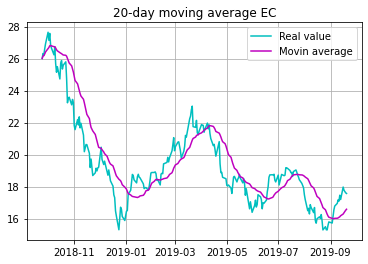

In [0]:
#http://research.iac.es/sieinvens/python-course/source/matplotlib.html
ObjWin=Window.orderBy(ObjEC.Date).rowsBetween(-20,0)
ObjMMEC=ObjEC.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjMMEC.set_index("Date")
ObjEC1.set_index("Date")
fig,ax=plt.subplots()
ax.plot(ObjEC1.Date, ObjEC1.Close,label="Real value",c='c')
ax.plot(ObjMMEC.Date, ObjMMEC.Mean,label="Movin average",c='m')
ax.set_title('20-day moving average EC')
ax.grid(True)
ax.legend()

**6.Graficar comportamiento del precio de cierre para las 3 acciones a lo largo del año.**


Se realiza una gráfica donde se obtenga el comportamiento solicitado de las acciones de las tres empresas.

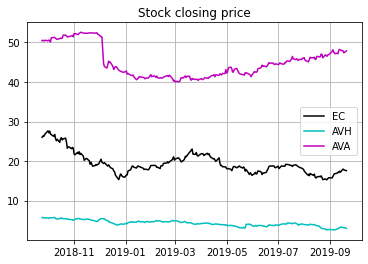

In [0]:
ObjACEC=ObjEC.select('Date','Close').toPandas()
ObjACAVH=ObjAVH.select('Date','Close').toPandas()
ObjACAVA=ObjAVA.select('Date','Close').toPandas()
fig,ax=plt.subplots()
ax.plot(ObjACEC.Date,ObjACEC.Close,label="EC",c='k')
ax.plot(ObjACAVH.Date,ObjACAVH.Close,label="AVH",c='c')
ax.plot(ObjACAVA.Date, ObjACAVA.Close,label="AVA",c='m')
ax.set_title('Stock closing price')
ax.grid(True)
ax.legend()

**Bandas de Bollinger**

Son unos indicadores utilizados en el análisis técnico de los mercados financieros. Fueron introducidos por John Bollinger en los años 1980.
La representación gráfica de las bandas de [Bollinger](https://www.avatrade.es/educacion/trading-para-principiantes/bandas-de-bollinger) son dos curvas que envuelven el gráfico de precios. Se calcula a partir de una media móvil (simple o exponencial) sobre el precio de cierre a la que envuelven dos bandas que se obtienen de añadir y sustraer al valor de la media K desviaciones estándar (habitualmente, K = 2). La distancia entre las curvas superior e inferior, igual a cuatro desviaciones estándar, es por lo tanto una medida de la volatilidad del precio del activo.

De acuerdo con el análisis técnico, el que los precios sobrepasen las bandas indica que el mercado está sobrecomprado (si lo hacen por arriba) o sobrevendido (si lo hacen por abajo).



1.   La banda central es una media móvil, normalmente se emplea una media móvil simple calculada con 20 períodos.
2.   La banda superior se calcula sumando al valor de la media móvil simple 2 veces la desviación típica de la media móvil.
3.   La banda inferior de calcula restando a la media móvil simple 2 veces la desviación típica de la media móvil




**7.Calcular y graficar franjas Bollinger para K=2.**


Franjas Bollinger para EC:

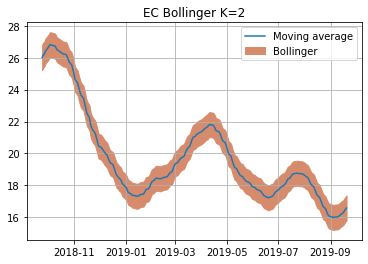

In [0]:
ObjCPEC=ObjEC.orderBy(ObjEC.Date).select('Close').toPandas()
ObjOPEC=ObjEC.orderBy(ObjEC.Date).select('Open').toPandas()
SDEC=np.std(np.array(ObjCPEC)-np.array(ObjOPEC))
BSEC=(ObjMMEC.Mean)+(SDEC*2)
BIEC=(ObjMMEC.Mean)-(SDEC*2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMEC.Date, BSEC, BIEC, color='#d68c6c',label='Bollinger')
ax.plot(ObjMMEC.Date, ObjMMEC.Mean, label="Moving average")
ax.set_title('EC Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVH:

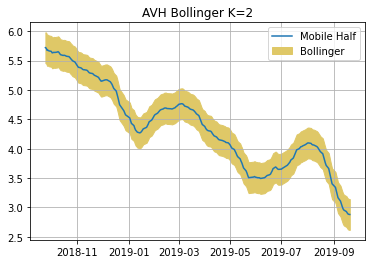

In [0]:
ObjWin= Window.orderBy(ObjAVH.Date).rowsBetween(-20,0)
ObjMMAVH=ObjAVH.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Close').toPandas()
ObjOPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Open').toPandas()
SDAVH=np.std(np.array(ObjCPAVH)-np.array(ObjOPAVH))
BSAVH=(ObjMMAVH.Mean)+(SDAVH *2)
BIAVH=(ObjMMAVH.Mean)-(SDAVH *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVH.Date,BSAVH,BIAVH, color='#dfc867',label='Bollinger')
ax.plot(ObjMMAVH.Date, ObjMMAVH.Mean, label="Mobile Half")
ax.set_title('AVH Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVA:

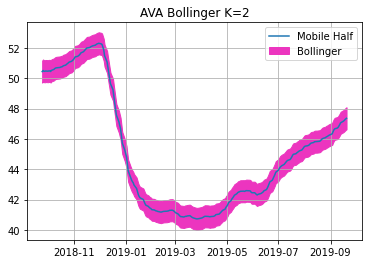

In [0]:
ObjWin= Window.orderBy(ObjAVA.Date).rowsBetween(-20,0)
ObjMMAVA=ObjAVA.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Close').toPandas()
ObjOPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Open').toPandas()
SDAVA=np.std(np.array(ObjCPAVA)-np.array(ObjOPAVA))
BSAVA=(ObjMMAVA.Mean)+(SDAVA *2)
BIAVA=(ObjMMAVA.Mean)-(SDAVA *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVA.Date,BSAVA,BIAVA, color='#ec35bf',label='Bollinger')
ax.plot(ObjMMAVA.Date, ObjMMAVA.Mean, label="Mobile Half")
ax.set_title('AVA Bollinger K=2')
ax.grid(True)
ax.legend()

**8.Para qué fechas la tendecia se sale de las franjas calculadas en el punto anterior?**

Para EC, esta representado con el precio de cierre:

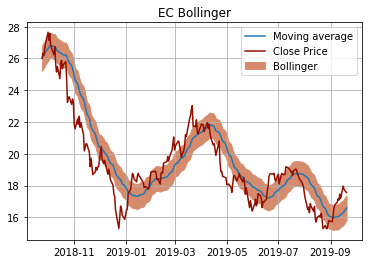

In [0]:
ObjCPEC=ObjEC.orderBy(ObjEC.Date).select('Close').toPandas()
ObjOPEC=ObjEC.orderBy(ObjEC.Date).select('Open').toPandas()
ObjEC1=ObjEC.toPandas()
SDEC=np.std(np.array(ObjCPEC)-np.array(ObjOPEC))
BSEC=(ObjMMEC.Mean)+(SDEC*2)
BIEC=(ObjMMEC.Mean)-(SDEC*2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMEC.Date, BSEC, BIEC, color='#d68c6c',label='Bollinger')
ax.plot(ObjMMEC.Date, ObjMMEC.Mean, label="Moving average")
ax.plot(ObjEC1.Date, ObjEC1.Close, label="Close Price",color='#920f00')
ax.set_title('EC Bollinger')
ax.grid(True)
ax.legend()

Para AVH, esta representado con el precio de cierre:

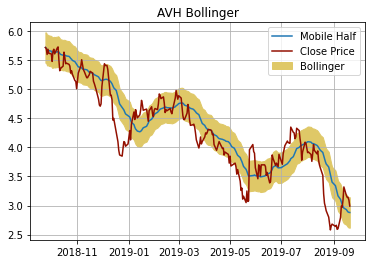

In [0]:
ObjWin= Window.orderBy(ObjAVH.Date).rowsBetween(-20,0)
ObjMMAVH=ObjAVH.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Close').toPandas()
ObjOPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Open').toPandas()
ObjAVH1=ObjAVH.toPandas()
SDAVH=np.std(np.array(ObjCPAVH)-np.array(ObjOPAVH))
BSAVH=(ObjMMAVH.Mean)+(SDAVH *2)
BIAVH=(ObjMMAVH.Mean)-(SDAVH *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVH.Date,BSAVH,BIAVH, color='#dfc867',label='Bollinger')
ax.plot(ObjMMAVH.Date, ObjMMAVH.Mean, label="Mobile Half")
ax.set_title('AVH Bollinger')
ax.plot(ObjAVH1.Date, ObjAVH1.Close, label="Close Price",color='#920f00')
ax.grid(True)
ax.legend()

Para AVA, esta representado con el precio de cierre:

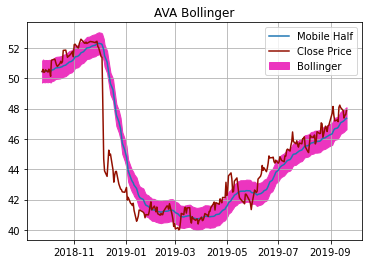

In [0]:
ObjWin= Window.orderBy(ObjAVA.Date).rowsBetween(-20,0)
ObjMMAVA=ObjAVA.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Close').toPandas()
ObjOPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Open').toPandas()
ObjAVA1=ObjAVA.toPandas()
SDAVA=np.std(np.array(ObjCPAVA)-np.array(ObjOPAVA))
BSAVA=(ObjMMAVA.Mean)+(SDAVA *2)
BIAVA=(ObjMMAVA.Mean)-(SDAVA *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVA.Date,BSAVA,BIAVA, color='#ec35bf',label='Bollinger')
ax.plot(ObjMMAVA.Date, ObjMMAVA.Mean, label="Mobile Half")
ax.plot(ObjAVA1.Date, ObjAVA1.Close, label="Close Price",color='#920f00')
ax.set_title('AVA Bollinger')
ax.grid(True)
ax.legend()

**9.Calcular y graficar las franjas Bollinger con K=2 y K=1.**

Franjas Bollinger para EC con K=1:

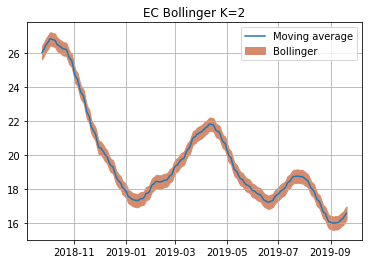

In [0]:
ObjCPEC=ObjEC.orderBy(ObjEC.Date).select('Close').toPandas()
ObjOPEC=ObjEC.orderBy(ObjEC.Date).select('Open').toPandas()
SDEC=np.std(np.array(ObjCPEC)-np.array(ObjOPEC))
BSEC=(ObjMMEC.Mean)+(SDEC*1)
BIEC=(ObjMMEC.Mean)-(SDEC*1)
fig, ax = plt.subplots()
ax.fill_between(ObjMMEC.Date, BSEC, BIEC, color='#d68c6c',label='Bollinger')
ax.plot(ObjMMEC.Date, ObjMMEC.Mean, label="Moving average")
ax.set_title('EC Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para EC con K=2:

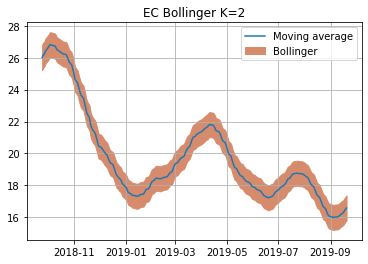

In [0]:
ObjCPEC=ObjEC.orderBy(ObjEC.Date).select('Close').toPandas()
ObjOPEC=ObjEC.orderBy(ObjEC.Date).select('Open').toPandas()
SDEC=np.std(np.array(ObjCPEC)-np.array(ObjOPEC))
BSEC=(ObjMMEC.Mean)+(SDEC*2)
BIEC=(ObjMMEC.Mean)-(SDEC*2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMEC.Date, BSEC, BIEC, color='#d68c6c',label='Bollinger')
ax.plot(ObjMMEC.Date, ObjMMEC.Mean, label="Moving average")
ax.set_title('EC Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVH con K=1:

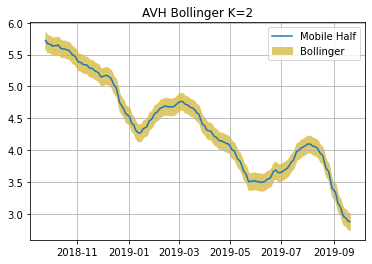

In [0]:
ObjWin= Window.orderBy(ObjAVH.Date).rowsBetween(-20,0)
ObjMMAVH=ObjAVH.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Close').toPandas()
ObjOPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Open').toPandas()
SDAVH=np.std(np.array(ObjCPAVH)-np.array(ObjOPAVH))
BSAVH=(ObjMMAVH.Mean)+(SDAVH *1)
BIAVH=(ObjMMAVH.Mean)-(SDAVH *1)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVH.Date,BSAVH,BIAVH, color='#dfc867',label='Bollinger')
ax.plot(ObjMMAVH.Date, ObjMMAVH.Mean, label="Mobile Half")
ax.set_title('AVH Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVH con K=2:

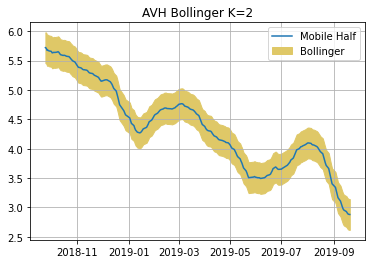

In [0]:
ObjWin= Window.orderBy(ObjAVH.Date).rowsBetween(-20,0)
ObjMMAVH=ObjAVH.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Close').toPandas()
ObjOPAVH=ObjAVH.orderBy(ObjAVH.Date).select('Open').toPandas()
SDAVH=np.std(np.array(ObjCPAVH)-np.array(ObjOPAVH))
BSAVH=(ObjMMAVH.Mean)+(SDAVH *2)
BIAVH=(ObjMMAVH.Mean)-(SDAVH *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVH.Date,BSAVH,BIAVH, color='#dfc867',label='Bollinger')
ax.plot(ObjMMAVH.Date, ObjMMAVH.Mean, label="Mobile Half")
ax.set_title('AVH Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVA con K=1:

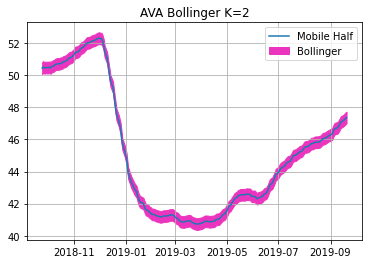

In [0]:
ObjWin= Window.orderBy(ObjAVA.Date).rowsBetween(-20,0)
ObjMMAVA=ObjAVA.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Close').toPandas()
ObjOPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Open').toPandas()
SDAVA=np.std(np.array(ObjCPAVA)-np.array(ObjOPAVA))
BSAVA=(ObjMMAVA.Mean)+(SDAVA *1)
BIAVA=(ObjMMAVA.Mean)-(SDAVA *1)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVA.Date,BSAVA,BIAVA, color='#ec35bf',label='Bollinger')
ax.plot(ObjMMAVA.Date, ObjMMAVA.Mean, label="Mobile Half")
ax.set_title('AVA Bollinger K=2')
ax.grid(True)
ax.legend()

Franjas Bollinger para AVA con K=2:

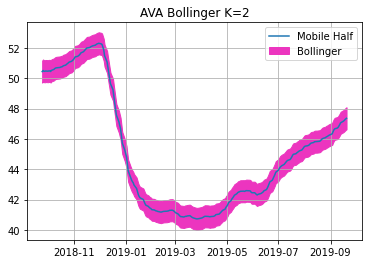

In [0]:
ObjWin= Window.orderBy(ObjAVA.Date).rowsBetween(-20,0)
ObjMMAVA=ObjAVA.select('Date', F.avg('Close').over(ObjWin).alias('Mean')).toPandas()
ObjCPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Close').toPandas()
ObjOPAVA=ObjAVA.orderBy(ObjAVA.Date).select('Open').toPandas()
SDAVA=np.std(np.array(ObjCPAVA)-np.array(ObjOPAVA))
BSAVA=(ObjMMAVA.Mean)+(SDAVA *2)
BIAVA=(ObjMMAVA.Mean)-(SDAVA *2)
fig, ax = plt.subplots()
ax.fill_between(ObjMMAVA.Date,BSAVA,BIAVA, color='#ec35bf',label='Bollinger')
ax.plot(ObjMMAVA.Date, ObjMMAVA.Mean, label="Mobile Half")
ax.set_title('AVA Bollinger K=2')
ax.grid(True)
ax.legend()

**10.Determinar para qué fechas es conveniente comprar usando la técnica de doble franja Bollinger.**

Para EC:

In [0]:
ObjDate=ObjEC.select('Date','Close', F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate[ObjDate['Close'] > ObjDate['Mean']].orderBy('Date').show()

+-------------------+---------+------------------+
|               Date|    Close|              Mean|
+-------------------+---------+------------------+
|2018-09-25 00:00:00|    26.32|            26.165|
|2018-09-26 00:00:00|26.219999|         26.183333|
|2018-09-27 00:00:00|26.610001|             26.29|
|2018-09-28 00:00:00|    26.93|            26.418|
|2018-10-01 00:00:00|    27.65|26.623333333333335|
|2018-10-02 00:00:00|27.139999|26.697142714285715|
|2018-10-03 00:00:00|    27.58|26.807499874999998|
|2018-10-04 00:00:00|26.860001|26.813333333333333|
|2018-12-03 00:00:00|20.459999|20.388571380952378|
|2019-01-07 00:00:00|    17.77|17.476190380952378|
|2019-01-08 00:00:00|18.280001|17.423809523809524|
|2019-01-09 00:00:00|    18.76| 17.38428571428571|
|2019-01-10 00:00:00|18.690001| 17.37285719047619|
|2019-01-11 00:00:00|    18.42| 17.35904771428572|
|2019-01-14 00:00:00|    18.23| 17.32047623809524|
|2019-01-15 00:00:00|18.620001| 17.31714290476191|
|2019-01-16 00:00:00|    18.77|

Para AVH:

In [0]:
ObjDate=ObjAVH.select('Date','Close',F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate=ObjDate[ObjDate['Close']<=ObjDate['Mean']].orderBy('Date').show()

+-------------------+-----+------------------+
|               Date|Close|              Mean|
+-------------------+-----+------------------+
|2018-09-24 00:00:00| 5.72|              5.72|
|2018-09-25 00:00:00|  5.7|              5.71|
|2018-09-26 00:00:00|  5.6| 5.673333333333333|
|2018-09-28 00:00:00| 5.62|             5.666|
|2018-10-01 00:00:00| 5.61| 5.656666666666667|
|2018-10-02 00:00:00| 5.48| 5.631428571428572|
|2018-10-05 00:00:00| 5.61|             5.638|
|2018-10-10 00:00:00|  5.5|              5.64|
|2018-10-11 00:00:00| 5.32|5.6171428571428565|
|2018-10-12 00:00:00| 5.36| 5.599999999999999|
|2018-10-15 00:00:00|  5.4|5.5874999999999995|
|2018-10-17 00:00:00| 5.55| 5.588333333333333|
|2018-10-18 00:00:00| 5.44| 5.580526315789473|
|2018-10-19 00:00:00| 5.45|             5.574|
|2018-10-22 00:00:00| 5.43| 5.567142857142857|
|2018-10-23 00:00:00|  5.4| 5.551904761904762|
|2018-10-24 00:00:00| 5.28| 5.531904761904762|
|2018-10-25 00:00:00| 5.32|  5.51857142857143|
|2018-10-26 0

Para AVA:

In [0]:
ObjDate=ObjAVA.select('Date','Close', F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate[ObjDate['Close'] > ObjDate['Mean']].orderBy('Date').show()

+-------------------+---------+------------------+
|               Date|    Close|              Mean|
+-------------------+---------+------------------+
|2018-09-25 00:00:00|    50.59|        50.5149995|
|2018-09-28 00:00:00|50.560001|50.479999400000004|
|2018-10-02 00:00:00|50.599998| 50.48714214285714|
|2018-10-05 00:00:00|51.189999|        50.5209995|
|2018-10-08 00:00:00|    51.25| 50.58727227272727|
|2018-10-09 00:00:00|    51.27| 50.64416624999999|
|2018-10-10 00:00:00|51.060001|50.676153538461534|
|2018-10-11 00:00:00|50.880001|50.690714071428566|
|2018-10-12 00:00:00|50.779999|        50.6966664|
|2018-10-15 00:00:00|50.970001|     50.7137498125|
|2018-10-16 00:00:00|51.119999| 50.73764682352941|
|2018-10-17 00:00:00|     51.0|50.752221999999996|
|2018-10-18 00:00:00|    51.09| 50.76999978947369|
|2018-10-19 00:00:00|    51.84|        50.8234998|
|2018-10-22 00:00:00|51.860001|         50.872857|
|2018-10-23 00:00:00|51.599998|50.928095047619045|
|2018-10-24 00:00:00|51.380001|

**11.Determinar para qué fechas es conveniente vender en corto la técnica de doble franja Bollinger.**

Para EC:

In [371]:
ObjWin=Window.orderBy(ObjEC.Date).rowsBetween(-20,0)
ObjDate=ObjEC.select('Date','Close',F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate=ObjDate[ObjDate['Close']<=ObjDate['Mean']].orderBy('Date').show()

+-------------------+---------+------------------+
|               Date|    Close|              Mean|
+-------------------+---------+------------------+
|2018-09-24 00:00:00|    26.01|             26.01|
|2018-10-05 00:00:00|    26.66|26.798000000000002|
|2018-10-08 00:00:00|    26.24| 26.74727272727273|
|2018-10-09 00:00:00|    26.74| 26.74666666666667|
|2018-10-10 00:00:00|25.690001|26.665384692307693|
|2018-10-11 00:00:00|    25.15| 26.55714292857143|
|2018-10-12 00:00:00|     25.5|26.486666733333333|
|2018-10-15 00:00:00|    24.73|     26.3768750625|
|2018-10-16 00:00:00|25.719999| 26.33823529411765|
|2018-10-17 00:00:00|25.879999|26.312777722222222|
|2018-10-18 00:00:00|    25.35|26.262105210526318|
|2018-10-19 00:00:00|    25.59|26.228499950000003|
|2018-10-22 00:00:00|25.799999|26.208095142857143|
|2018-10-23 00:00:00|    24.74|26.147618952380952|
|2018-10-24 00:00:00|    23.24|26.000952285714284|
|2018-10-25 00:00:00|    23.52|25.872380904761908|
|2018-10-26 00:00:00|    23.59|

Para AVH:

In [374]:
ObjWin=Window.orderBy(ObjAVH.Date).rowsBetween(-20,0)
ObjDate=ObjAVH.select('Date','Close',F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate=ObjDate[ObjDate['Close']<=ObjDate['Mean']].orderBy('Date').show()

+-------------------+-----+------------------+
|               Date|Close|              Mean|
+-------------------+-----+------------------+
|2018-09-24 00:00:00| 5.72|              5.72|
|2018-09-25 00:00:00|  5.7|              5.71|
|2018-09-26 00:00:00|  5.6| 5.673333333333333|
|2018-09-28 00:00:00| 5.62|             5.666|
|2018-10-01 00:00:00| 5.61| 5.656666666666667|
|2018-10-02 00:00:00| 5.48| 5.631428571428572|
|2018-10-05 00:00:00| 5.61|             5.638|
|2018-10-10 00:00:00|  5.5|              5.64|
|2018-10-11 00:00:00| 5.32|5.6171428571428565|
|2018-10-12 00:00:00| 5.36| 5.599999999999999|
|2018-10-15 00:00:00|  5.4|5.5874999999999995|
|2018-10-17 00:00:00| 5.55| 5.588333333333333|
|2018-10-18 00:00:00| 5.44| 5.580526315789473|
|2018-10-19 00:00:00| 5.45|             5.574|
|2018-10-22 00:00:00| 5.43| 5.567142857142857|
|2018-10-23 00:00:00|  5.4| 5.551904761904762|
|2018-10-24 00:00:00| 5.28| 5.531904761904762|
|2018-10-25 00:00:00| 5.32|  5.51857142857143|
|2018-10-26 0

Para AVA:

In [375]:
ObjWin=Window.orderBy(ObjAVA.Date).rowsBetween(-20,0)
ObjDate=ObjAVA.select('Date','Close',F.avg('Close').over(ObjWin).alias('Mean'))
ObjDate=ObjDate[ObjDate['Close']<=ObjDate['Mean']].orderBy('Date').show()

+-------------------+---------+------------------+
|               Date|    Close|              Mean|
+-------------------+---------+------------------+
|2018-09-24 00:00:00|50.439999|         50.439999|
|2018-09-26 00:00:00|50.389999| 50.47333266666667|
|2018-09-27 00:00:00|50.419998|         50.459999|
|2018-10-01 00:00:00|    50.41|50.468332833333335|
|2018-10-03 00:00:00|    50.48|      50.486249375|
|2018-10-04 00:00:00|50.130001| 50.44666622222222|
|2018-11-29 00:00:00|52.099998| 52.28047595238094|
|2018-11-30 00:00:00|    52.02| 52.30904747619046|
|2018-12-03 00:00:00|51.419998|  52.2709520952381|
|2018-12-04 00:00:00|51.389999| 52.22999966666666|
|2018-12-06 00:00:00|    44.68| 51.87999971428572|
|2018-12-07 00:00:00|43.889999| 51.49380919047618|
|2018-12-10 00:00:00|43.529999| 51.07714252380953|
|2018-12-11 00:00:00|44.450001|50.697142571428564|
|2018-12-12 00:00:00|45.259998| 50.34857095238095|
|2018-12-13 00:00:00|    44.93| 49.99285657142857|
|2018-12-14 00:00:00|     45.0|